# Duboko učenje - laboratorijska vježba - generativni modeli - Generative adversarial networks (GAN)

Primarna namjena GAN-a je isto generiranje novih i uvjerljivih uzoraka, no princip rada je malo drugačiji od prethodna dva modela. GAN ne procjenjuje direktno parametre $p(\mathbf x)$ ili bilo koje druge distribucije, premda se njegovo treniranje može interpretirati kao estimacija $p(\mathbf x)$. Najvjerojatnije zahvaljujući tom drugačijem pristupu, GAN-ovi često generiraju vizualno najbolje uzorke u usporedbi sa VAE ili drugim generativnim mrežama.

GAN se sastoji od dvije zasebne mreže 

1. Generator (G) koji ima zadatak generirati uvjerljive uzorke
2. Diskriminator (D) koji ima zadatak prepoznati radi li se o pravom uzorku (iz skupa za treniranje) ili lažnom uzorku koji je generirao G

<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/GAN.svg" width="30%">
</div>
</center>

Te dvije mreže su protivnici (Adversaries), imaju dijametralno suprotstavljene ciljeve te se pokušavaju nadmudriti. To nadmetanje ih tjera da budu sve bolji u postizanju svog cilja i da se fokusiraju na sve bitne detalje ulaznih podataka. Očekivano, njihovo nadmetanje trebalo bi dovesti do toga da generator generira savršene uzorke koje diskriminator ne može razlikovati od uzoraka iz skupa za treniranje. Da bi generator postigao takav uspjeh nužno je da i diskriminator bude maksimalno dobar u svom zadatku.

Generator na svojem izlazu generira uzorke za neki slučajni ulazni vektor koji prati neku distribuciju. Ta slučajnost na ulazu omogućuje generatoru da uvijek generira nove uzorke. Pri tome nema nekih posebnih ograničenja na arhitekturu generatora, no poželjno je da se može trenirati backpropagation algoritmom. 

<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/G.svg" width="30%">
</div>
</center>

Diskriminator na svome izlazu treba estimirati pripadnost razredu stvarnih ili lažnih uzoraka za svaki ulazni vektor. Za razliku od generatora, ovdje je moguće koristiti učenje pod nadzorom jer se za svaki uzorak zna da li je došao iz skupa za treniranje ili od generatora. Radi jednostavnosti možemo izlaz diskriminatora ograničiti u rasponu $[0,1]$ i interpretirati kao vjerojatnost da je ulazni uzorak stvaran (iz skupa za treniranje).

    
<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/D.svg" width="30%">
</div>
</center>
    

Gore opisani ciljevi diskriminatora i generatora mogu se formalno izraziti u sljedećoj funkciji cilja:

$\min_G \max_D V(D,G) = E_{ \mathbf x \sim p_{data}(\mathbf x) } [\log D( \mathbf x)] + E_{ \mathbf z  \sim p_{\mathbf z}(\mathbf z) } [\log(1 - D(G( \mathbf z)))]$

Prvi pribrojnik predstavlja očekivanje procjene log vjerojatnosti da su uzorci iz skupa za treniranje stvarni. Drugi pribrojnik predstavlja očekivanje procjene log vjerojatnosti da generirani uzorci nisu stvarni, tj. da su umjetni. Diskriminator ima za cilj maksimizirati oba pribrojnika, dok generator ima za cilj minimizirati drugi pribrojnik. Svaki pribrojnik funkcije cilja može se jednostavno procijeniti za jednu mini grupu te se može procijeniti gradijent s obzirom na prametre obiju mreža. 

Treniranje dviju mreža (G i D) može se provesti istovremeno ili se u jednoj iteraciji prvo može trenirati jedna mreža a zatim druga. Dodatno, neki autori preporučuju da se u nekoliko uzastopnih iteracija trenira jedna mreža, a nakon toga druga mreža samo jednu iteraciju.

    
<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/GAN2.svg" width="50%">
</div>
</center>


Kod generiranja slika uspješnim se pokazao Deep Convolutional GAN (DCGAN) koji u skrivenim slojevima obiju mreža koristi konvolucijske slojeve. Za razliku od klasičnih konvolucijskih mreža, ovdje se ne koriste pooling slojevi nego se uzorkovanje provodi pomoću konvolucijskih slojeva koji imaju posmak veći od 1. Autori mreže preporučuju korištenje Batch normalizacije u svim slojevima osim u izlaznom sloju generatora te ulaznom i izlaznom sloju diskriminatora. Korištenje Leaky ReLU aktivacijskih funkcija u svim slojevima osim u izlaznim je još jedna specifičnost DCGAN-a kao i eliminacija potpuno povezanih slojeva.

    
<center>
<div class="fig figcenter fighighlight">
  <img src="https://dlunizg.github.io/assets/lab4/DCGAN.svg" width="50%">
</div>
</center>

### U sljedećih nekoliko blokova koda nalaze se inicijalizacijske postavke i gotove pomoćne funkcije

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torchvision import datasets, transforms
import tqdm
from torchvision.utils import make_grid

import torch.distributions as tdist

import numpy as np
import tqdm

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
'''
def prepare_data_loaders(batch_size=32):
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(64),
                                    torchvision.transforms.ToTensor()
                               ])), batch_size=batch_size)

    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./files', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.Resize(64),
                                       torchvision.transforms.ToTensor()
                                   ])), batch_size=batch_size)
    
    return train_loader, test_loader
'''

def prepare_data_loaders(batch_size=32):

    transform = torchvision.transforms.Compose([
        torchvision.transforms.Pad(18),
        torchvision.transforms.ToTensor()
    ])

    train_dataset = torchvision.datasets.MNIST('./files', train=True, download=True, transform=transform)
    test_dataset  = torchvision.datasets.MNIST('./files', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )

    return train_loader, test_loader

### Zadatak

Implementirajte DCGAN s generatorom i diskriminatorom. Arhitekura treba biti:
    
* Generator
    * Sloj 1 - Broj izlaznih kanala = 512, veličina jezgre = 4, veličina koraka = 1
    * Sloj 2 - Broj izlaznih kanala = 256, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 3 - Broj izlaznih kanala = 128, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 4 - Broj izlaznih kanala = 64, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 5 - Broj izlaznih kanala = 1, veličina jezgre = 4, veličina koraka = 2, padding = 1

* Diskriminator
    * Sloj 1 - Broj izlaznih konvolucija = 64, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 2 - Broj izlaznih konvolucija = 128, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 3 - Broj izlaznih konvolucija = 256, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 4 - Broj izlaznih konvolucija = 512, veličina jezgre = 4, veličina koraka = 2, padding = 1
    * Sloj 5 - Broj izlaznih konvolucija = 1, veličina jezgre = 4, veličina koraka = 1, padding = 0

Ulaz u generator $\mathbf z$ neka ima 100 elemenata prema normalnoj distribuciji $N(0,1)$. Ulazni podaci neka su MNIST brojevi skalirani na veličinu 64x64 te treniranje provedite kroz barem 20 epoha. U jednoj iteraciji provedite jednu optimizaciju generatora i jednu optimizaciju diskriminatora s po jednom mini grupom. Koristite tanh aktivacijsku funkciju za izlaz generatora i sigmoid aktivaciju za izlaz diskriminator, a za ostaje slojeve "propustljivi" ReLU sa "negative_slope" parametrom od 0.2. Batch normalizacija (jedan od podzadataka) ide iza svakog sloja.

**Podzadaci:**

 1. Vizualizirajte rezultate generiranja 100 novih uzoraka iz slučajnih vektora $\mathbf z$.
 2. Spremite težine istreniranog modela u datoteku "zad_gan.th" i uploadajte tu datoteku na Moodle.
 3. Na Moodle predajte vizualizaciju 1. podzadatka.
 4. Odgovorite na sljedeća pitanja **u bilježnici**. Bilježnicu na kraju predajte na Moodle.


Koristite sljedeći predložak:

**NAPOMENA**: Osim nadopunjavanja koda koji nedostaje, predložak se treba prilagođavati prema potrebi, a može i prema vlastitim preferencijama. Stoga **budite oprezni s tvrdnjama da vam neki dio koda ne radi!**

**Pitanje:**
    
U jednoj iteraciji provedite treniranje diskriminatora s dvije minigrupe, a generatora s jednom minigrupom. Ponovite isti postupak samo zamijenite mjesta generatora i diskriminatora. Vizualizirajte generirane uzorke i komentirajte rezultate.

**Odgovor:**

1. Slučaj: Diskriminator 2x, Generator 1x

    Generator generira gotovo identičan oblik svaki put (izgleda kao dio dvojke). Gubitak D brzo pada na nulu ili divlja, dok gubitak G pada na nulu (odustao je, funkcija gubitka je kolabirala). 

    Kada treniramo D 2x češće, on postaje previše dobar prebrzo u odnosu na generator. U ranoj fazi, ako je diskriminator savršen (razlikuje 100% točno), gradijenti koji se šalju natrag generatoru nestaju. Generator ne dobiva korisnu informaciju kako da se popravi, već samo informaciju da je "sve krivo". Posljedica toga je kolaps modova. Generator pronađe jedan jedini uzorak koji minimalno zavara diskriminator (ili se zaglavi u lokalnom minimumu) i počne generirati samo taj uzorak jer mu je to "najsigurnija oklada". 

2. Slučaj: Diskriminator 1x, Generator 2x

    Rezultat je vizualno solidan, vidimo različite rezultate (sedmice, trojke, nule), što znači da je generator zadržao raznolikost. Iako gubitak također divlja, slike su ostale koherentne. Davanjem prednosti G, omogućili smo mu da uhvati korak s D. D ima lakši zadatak od G, pa treniranjem generatora dvaput, on dobiva jače signale za promjenu prije nego što ga diskriminator ponovno "kazni". To je spriječilo diskriminatora da postane previše dominantan prerano.

**Pitanje:**

Isključite batch normalizaciju u obje mreže. Komentirajte rezultate.

**Odgovor:**

Zanimljivo je da vizualno slike bez BN-a, izgledaju čak "oštrije" od nekih drugih slučajeva, ali uz šum i artefakte. Bez BN-a, mreža nema mehanizam koji sprečava da jedan neuron preuzme cijelu aktivaciju. Treniranje je bilo stabilno do 14. epohe, a onda dolazi do numeričke eksplozije, tj. katastrofalnog zaboravljanja.

U svim slučajevima, dolazi do gubitka ravnoteže između mreža. Vrijednosti d_loss = 100 i g_loss = 0 ukazuju na zasićenje diskriminatora. U slučaju D:2x, do zasićenja dolazi zbog namjerne prednosti dane diskriminatoru, što uzrokuje mode collapse. U slučaju bez BN, do zasićenja dolazi zbog numeričke nestabilnosti; bez normalizacije, gradijenti postaju nekontrolirani, što dovodi do naglog 'pucanja' modela. Pad g_loss na nulu nije znak uspjeha, već znak da je G u stanju u kojem više ne dobiva korisne povratne informacije (gradijente) od D. Za 20 epoha. U svim slučajevima je došlo do neuspjeha treniranja.

In [22]:
'''
Generator koristi transponirane konvolucije (ConvTranspose2d) za povećanje dimenzionalnosti 
(upsampling) iz latentnog vektora do slike dimenzija 64x64. 
Batch normalizacija se koristi nakon svakog sloja osim izlaznog.
'''

class Generator(nn.Module):
    def __init__(self, latent_size=100):
        super(Generator, self).__init__()
        self.latent_size = latent_size

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.tanh = nn.Tanh()
        
        # Sloj 1: Input (N, 100, 1, 1) -> Output (N, 512, 4, 4)
        self.ct1 = nn.ConvTranspose2d(latent_size, 512, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(512)
        
        # Sloj 2: Input (N, 512, 4, 4) -> Output (N, 256, 8, 8)
        self.ct2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(256)
        
        # Sloj 3: Input (N, 256, 8, 8) -> Output (N, 128, 16, 16)
        self.ct3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Sloj 4: Input (N, 128, 16, 16) -> Output (N, 64, 32, 32)
        self.ct4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        # Sloj 5: Input (N, 64, 32, 32) -> Output (N, 1, 64, 64)
        self.ct5 = nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False)

    def forward(self, x):
        # Propagacija kroz slojeve: ConvT -> BatchNorm -> Activation
        x = self.ct1(x)
        x = self.bn1(x)
        x = self.lrelu(x)
        
        x = self.ct2(x)
        x = self.bn2(x)
        x = self.lrelu(x)
        
        x = self.ct3(x)
        x = self.bn3(x)
        x = self.lrelu(x)
        
        x = self.ct4(x)
        x = self.bn4(x)
        x = self.lrelu(x)
        
        x = self.ct5(x)
        out = self.tanh(x) # Izlazni sloj koristi Tanh
        
        return out

In [23]:
### Generator BEZ Batch Normalizacije
class GeneratorNoBN(nn.Module):
    def __init__(self, latent_size=100):
        super(GeneratorNoBN, self).__init__()
        self.latent_size = latent_size

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.tanh = nn.Tanh()
        
        # Sloj 1: Input (N, 100, 1, 1) -> Output (N, 512, 4, 4)
        self.ct1 = nn.ConvTranspose2d(latent_size, 512, 4, 1, 0, bias=True) # Bias je True jer nema BN
        
        # Sloj 2: Input (N, 512, 4, 4) -> Output (N, 256, 8, 8)
        self.ct2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=True)
        
        # Sloj 3: Input (N, 256, 8, 8) -> Output (N, 128, 16, 16)
        self.ct3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=True)
        
        # Sloj 4: Input (N, 128, 16, 16) -> Output (N, 64, 32, 32)
        self.ct4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True)
        
        # Sloj 5: Input (N, 64, 32, 32) -> Output (N, 1, 64, 64)
        self.ct5 = nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=True)

    def forward(self, x):
        # Nema BN: ConvT -> Activation
        x = self.lrelu(self.ct1(x))
        x = self.lrelu(self.ct2(x))
        x = self.lrelu(self.ct3(x))
        x = self.lrelu(self.ct4(x))
        
        out = self.tanh(self.ct5(x))
        
        return out

In [24]:
'''
Diskriminator koristi standardne konvolucije (Conv2d) za smanjenje dimenzionalnosti 
(downsampling) i klasifikaciju slike kao stvarne ili lažne. 
Batch normalizacija se ne koristi na ulaznom sloju diskriminatora ni na izlaznom sloju.
'''

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        
        # Sloj 1: Input (N, 1, 64, 64) -> Output (N, 64, 32, 32)
        # Nema Batch Normalizacije na ulazu diskriminatora
        self.cv1 = nn.Conv2d(1, 64, 4, 2, 1, bias=False)
        
        # Sloj 2: Input (N, 64, 32, 32) -> Output (N, 128, 16, 16)
        self.cv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        
        # Sloj 3: Input (N, 128, 16, 16) -> Output (N, 256, 8, 8)
        self.cv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Sloj 4: Input (N, 256, 8, 8) -> Output (N, 512, 4, 4)
        self.cv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        
        # Sloj 5: Input (N, 512, 4, 4) -> Output (N, 1, 1, 1)
        # Nema Batch Normalizacije na izlazu, koristi se Sigmoid
        self.cv5 = nn.Conv2d(512, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = self.cv1(x)
        x = self.lrelu(x)
        
        x = self.cv2(x)
        x = self.bn2(x)
        x = self.lrelu(x)
        
        x = self.cv3(x)
        x = self.bn3(x)
        x = self.lrelu(x)
        
        x = self.cv4(x)
        x = self.bn4(x)
        x = self.lrelu(x)
        
        x = self.cv5(x)
        out = self.sigmoid(x)
        
        return out.squeeze() # Uklanja dimenzije veličine 1 (N, 1, 1, 1) -> (N)

In [25]:
### Diskriminator BEZ Batch Normalizacije
class DiscriminatorNoBN(nn.Module):
    def __init__(self):
        super(DiscriminatorNoBN, self).__init__()

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        
        # Sloj 1: (N, 1, 64, 64) -> (N, 64, 32, 32). Prvi sloj nema BN.
        self.cv1 = nn.Conv2d(1, 64, 4, 2, 1, bias=True)
        
        # Sloj 2: (N, 64, 32, 32) -> (N, 128, 16, 16)
        self.cv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=True)
        
        # Sloj 3: (N, 128, 16, 16) -> (N, 256, 8, 8)
        self.cv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=True)
        
        # Sloj 4: (N, 256, 8, 8) -> (N, 512, 4, 4)
        self.cv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=True)
        
        # Sloj 5: (N, 512, 4, 4) -> (N, 1, 1, 1). Izlazni sloj nema BN.
        self.cv5 = nn.Conv2d(512, 1, 4, 1, 0, bias=True)

    def forward(self, x):
        x = self.lrelu(self.cv1(x))
        x = self.lrelu(self.cv2(x))
        x = self.lrelu(self.cv3(x))
        x = self.lrelu(self.cv4(x))
        
        out = self.sigmoid(self.cv5(x))
        
        return out.squeeze()

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def train(gmodel: Generator | GeneratorNoBN, dmodel: Discriminator | DiscriminatorNoBN, n_epochs=10, log_epochs=1, batch_size=32, learning_rate=1e-3, device='cpu',
          d_updates=1, g_updates=1):
    
    train_loader, test_loader = prepare_data_loaders(batch_size=batch_size)
    
    gmodel = gmodel.to(device)
    dmodel = dmodel.to(device)
    
    gmodel.train()
    dmodel.train()
    
    criterion = nn.BCELoss()
    
    g_optim = optim.Adam(gmodel.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    d_optim = optim.Adam(dmodel.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
    for epoch_idx in range(0, n_epochs):
        
        g_loss_accum, d_loss_accum = 0, 0
        
        for image_data, _ in tqdm.tqdm(train_loader):

            current_batch_size = image_data.shape[0] # Stvarna veličina batcha (zadnji batch može biti manji)
            image_data = image_data.to(device, non_blocking=True)

            # ------------------------------------
            #  1. Train Discriminator (D_updates puta)
            # ------------------------------------
            for _ in range(d_updates):
                dmodel.zero_grad(set_to_none=True)
                
                # --- Real data pass ---
                labels_real = torch.ones(current_batch_size, device=device)
                d_output_real = dmodel(image_data)
                d_err_real = criterion(d_output_real, labels_real)

                # --- Fake data pass ---
                # Novi noise za svaki D update
                noise = torch.randn(current_batch_size, 100, 1, 1, device=device) 
                fake_image_data = gmodel(noise)
                
                labels_fake = torch.zeros(current_batch_size, device=device)
                # .detach() kako ne bismo računali gradijente za generator u ovom koraku
                d_output_fake = dmodel(fake_image_data.detach())
                d_err_fake = criterion(d_output_fake, labels_fake)

                d_loss = d_err_real + d_err_fake
                d_loss.backward()
                d_optim.step()
                
                # Akumulacija gubitka samo za logiranje
                d_loss_accum += d_loss.detach()


            # ------------------------------------
            #  2. Train Generator (G_updates puta)
            # ------------------------------------
            for _ in range(g_updates):
                gmodel.zero_grad(set_to_none=True)
                
                # Generiranje novog noise vektora
                noise = torch.randn(current_batch_size, 100, 1, 1, device=device)
                fake_image_data = gmodel(noise)

                # Želimo da D misli da su slike PRAVE (label=1)
                labels_g = torch.ones(current_batch_size, device=device)
                d_output_g = dmodel(fake_image_data) 
                
                g_loss = criterion(d_output_g, labels_g)
                g_loss.backward()
                g_optim.step()
                
                # Akumulacija gubitka
                g_loss_accum += g_loss.detach()
            
        # Normalizacija gubitka po broju batcheva
        d_loss_avg = d_loss_accum / (len(train_loader) * d_updates)
        g_loss_avg = g_loss_accum / (len(train_loader) * g_updates)
            
        if (epoch_idx + 1) % log_epochs == 0:
            print(f"[{epoch_idx+1}/{n_epochs} - D:{d_updates}x / G:{g_updates}x]: d_loss = {d_loss_avg:.5f} g_loss = {g_loss_avg:.5f}")
            
    gmodel.eval()
    dmodel.eval()
    
    return gmodel, dmodel

--- Treniranje: D:1x, G:1x (default)---


100%|██████████| 469/469 [00:17<00:00, 27.55it/s]


[1/20 - D:1x / G:1x]: d_loss = 0.14265 g_loss = 8.06975


100%|██████████| 469/469 [00:16<00:00, 28.00it/s]


[2/20 - D:1x / G:1x]: d_loss = 0.19184 g_loss = 5.22001


100%|██████████| 469/469 [00:16<00:00, 28.00it/s]


[3/20 - D:1x / G:1x]: d_loss = 0.18217 g_loss = 4.91201


100%|██████████| 469/469 [00:16<00:00, 27.99it/s]


[4/20 - D:1x / G:1x]: d_loss = 0.07078 g_loss = 6.25109


100%|██████████| 469/469 [00:16<00:00, 27.99it/s]


[5/20 - D:1x / G:1x]: d_loss = 0.00201 g_loss = 7.87722


100%|██████████| 469/469 [00:16<00:00, 27.98it/s]


[6/20 - D:1x / G:1x]: d_loss = 0.13241 g_loss = 7.64662


100%|██████████| 469/469 [00:16<00:00, 28.00it/s]


[7/20 - D:1x / G:1x]: d_loss = 0.17082 g_loss = 5.25725


100%|██████████| 469/469 [00:16<00:00, 27.99it/s]


[8/20 - D:1x / G:1x]: d_loss = 0.15108 g_loss = 5.48173


100%|██████████| 469/469 [00:16<00:00, 27.88it/s]


[9/20 - D:1x / G:1x]: d_loss = 0.00329 g_loss = 7.23253


100%|██████████| 469/469 [00:16<00:00, 27.87it/s]


[10/20 - D:1x / G:1x]: d_loss = 0.17538 g_loss = 6.58870


100%|██████████| 469/469 [00:16<00:00, 27.87it/s]


[11/20 - D:1x / G:1x]: d_loss = 0.03658 g_loss = 5.88664


100%|██████████| 469/469 [00:16<00:00, 27.89it/s]


[12/20 - D:1x / G:1x]: d_loss = 0.30197 g_loss = 6.39693


100%|██████████| 469/469 [00:16<00:00, 27.89it/s]


[13/20 - D:1x / G:1x]: d_loss = 0.01360 g_loss = 6.19655


100%|██████████| 469/469 [00:16<00:00, 27.88it/s]


[14/20 - D:1x / G:1x]: d_loss = 0.04832 g_loss = 6.57343


100%|██████████| 469/469 [00:16<00:00, 27.88it/s]


[15/20 - D:1x / G:1x]: d_loss = 0.05712 g_loss = 6.62860


100%|██████████| 469/469 [00:16<00:00, 27.87it/s]


[16/20 - D:1x / G:1x]: d_loss = 0.39840 g_loss = 6.61192


100%|██████████| 469/469 [00:16<00:00, 27.89it/s]


[17/20 - D:1x / G:1x]: d_loss = 0.01164 g_loss = 6.70068


100%|██████████| 469/469 [00:16<00:00, 27.89it/s]


[18/20 - D:1x / G:1x]: d_loss = 0.25754 g_loss = 7.09193


100%|██████████| 469/469 [00:16<00:00, 27.88it/s]


[19/20 - D:1x / G:1x]: d_loss = 0.05280 g_loss = 6.61498


100%|██████████| 469/469 [00:16<00:00, 27.88it/s]


[20/20 - D:1x / G:1x]: d_loss = 0.11515 g_loss = 6.49950


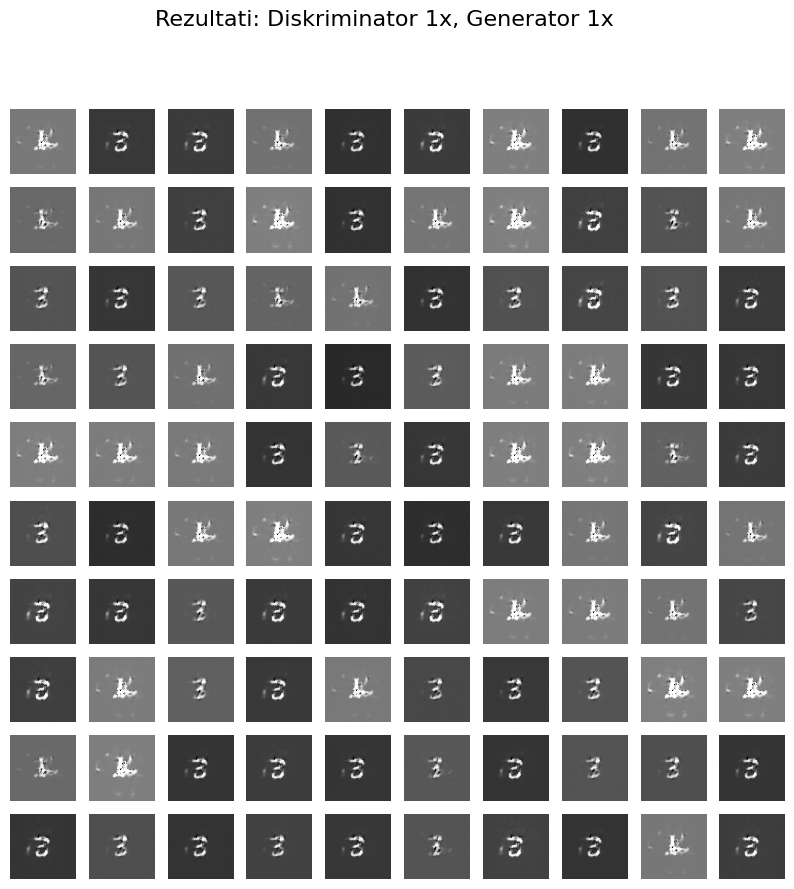

In [35]:
gmodel_d1g1 = Generator()
dmodel_d1g1 = Discriminator()

print("--- Treniranje: D:1x, G:1x (default)---")
gmodel_d1g1, dmodel_d1g1 = train(gmodel_d1g1, dmodel_d1g1, n_epochs=20, batch_size=128, device=device, d_updates=1, g_updates=1, learning_rate=2e-4)

random_sample_d1g1 = gmodel_d1g1(torch.randn(100, 100, 1, 1).to(device)).view(100, 64, 64).data.cpu().numpy()
plt.figure(figsize=(10, 10))
for idx in range(100):
    plt.subplot(10, 10, idx+1)
    plt.imshow(random_sample_d1g1[idx, ...], cmap='gray')
    plt.axis('off')
plt.suptitle('Rezultati: Diskriminator 1x, Generator 1x', fontsize=16)
plt.show()

--- Treniranje: D:2x, G:1x ---


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[1/20 - D:2x / G:1x]: d_loss = 0.66477 g_loss = 9.13687


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[2/20 - D:2x / G:1x]: d_loss = 39.27120 g_loss = 7.39065


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[3/20 - D:2x / G:1x]: d_loss = 14.86825 g_loss = 10.54878


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[4/20 - D:2x / G:1x]: d_loss = 0.32031 g_loss = 7.73036


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[5/20 - D:2x / G:1x]: d_loss = 0.00497 g_loss = 9.31980


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[6/20 - D:2x / G:1x]: d_loss = 0.00082 g_loss = 10.95822


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[7/20 - D:2x / G:1x]: d_loss = 0.30049 g_loss = 9.88344


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[8/20 - D:2x / G:1x]: d_loss = 0.75632 g_loss = 7.51407


100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


[9/20 - D:2x / G:1x]: d_loss = 42.40541 g_loss = 31.73664


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[10/20 - D:2x / G:1x]: d_loss = 0.41505 g_loss = 7.53418


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[11/20 - D:2x / G:1x]: d_loss = 134.54739 g_loss = 2.31902


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[12/20 - D:2x / G:1x]: d_loss = 200.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


[13/20 - D:2x / G:1x]: d_loss = 200.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[14/20 - D:2x / G:1x]: d_loss = 200.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[15/20 - D:2x / G:1x]: d_loss = 200.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


[16/20 - D:2x / G:1x]: d_loss = 200.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[17/20 - D:2x / G:1x]: d_loss = 200.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[18/20 - D:2x / G:1x]: d_loss = 200.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


[19/20 - D:2x / G:1x]: d_loss = 200.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


[20/20 - D:2x / G:1x]: d_loss = 200.00000 g_loss = 0.00000


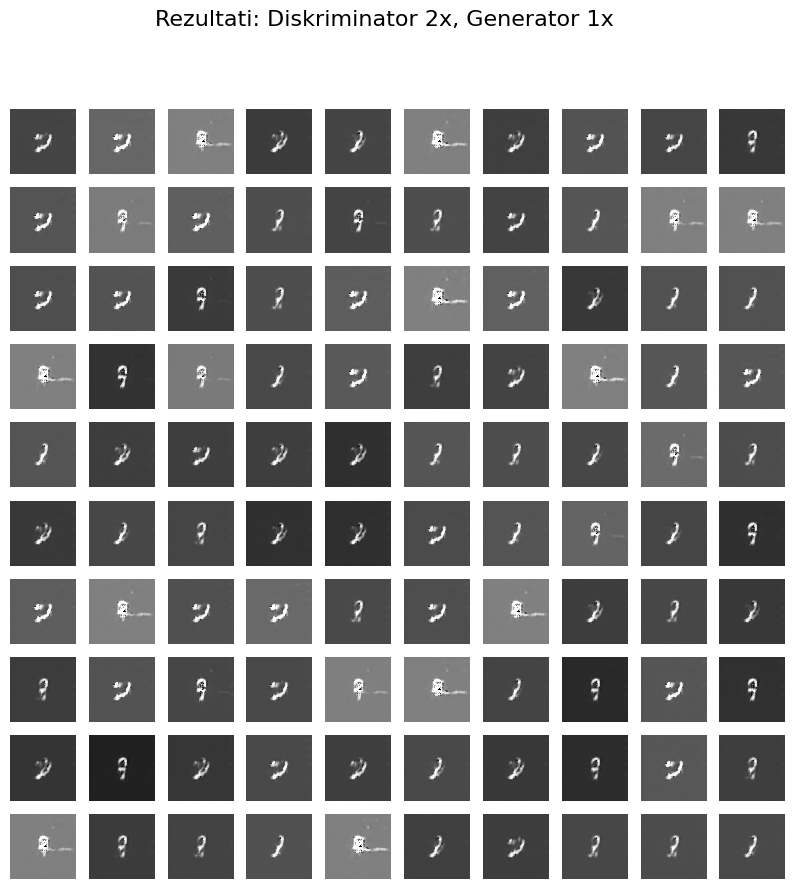

In [30]:
gmodel_d2g1 = Generator()
dmodel_d2g1 = Discriminator()

# Ovo je scenarij u kojem D ima više prilika za učenje
print("--- Treniranje: D:2x, G:1x ---")
gmodel_d2g1, dmodel_d2g1 = train(gmodel_d2g1, dmodel_d2g1, n_epochs=20, batch_size=128, device=device, d_updates=2, g_updates=1)

random_sample_d2g1 = gmodel_d2g1(torch.randn(100, 100, 1, 1).to(device)).view(100, 64, 64).data.cpu().numpy()
plt.figure(figsize=(10, 10))
for idx in range(100):
    plt.subplot(10, 10, idx+1)
    plt.imshow(random_sample_d2g1[idx, ...], cmap='gray')
    plt.axis('off')
plt.suptitle('Rezultati: Diskriminator 2x, Generator 1x', fontsize=16)
plt.show()

--- Treniranje: D:1x, G:2x ---


100%|██████████| 469/469 [00:24<00:00, 18.94it/s]


[1/20 - D:1x / G:2x]: d_loss = 0.63254 g_loss = 9.50180


100%|██████████| 469/469 [00:24<00:00, 18.93it/s]


[2/20 - D:1x / G:2x]: d_loss = 0.22315 g_loss = 12.03916


100%|██████████| 469/469 [00:24<00:00, 18.93it/s]


[3/20 - D:1x / G:2x]: d_loss = 0.17758 g_loss = 12.36749


100%|██████████| 469/469 [00:24<00:00, 18.93it/s]


[4/20 - D:1x / G:2x]: d_loss = 0.31553 g_loss = 13.59854


100%|██████████| 469/469 [00:24<00:00, 18.92it/s]


[5/20 - D:1x / G:2x]: d_loss = 0.18181 g_loss = 11.62129


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[6/20 - D:1x / G:2x]: d_loss = 0.14413 g_loss = 14.11935


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[7/20 - D:1x / G:2x]: d_loss = 0.06337 g_loss = 15.89653


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[8/20 - D:1x / G:2x]: d_loss = 0.12202 g_loss = 14.25856


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[9/20 - D:1x / G:2x]: d_loss = 0.00620 g_loss = 15.10272


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[10/20 - D:1x / G:2x]: d_loss = 88.28650 g_loss = 1.99824


100%|██████████| 469/469 [00:24<00:00, 18.85it/s]


[11/20 - D:1x / G:2x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[12/20 - D:1x / G:2x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[13/20 - D:1x / G:2x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:24<00:00, 18.85it/s]


[14/20 - D:1x / G:2x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[15/20 - D:1x / G:2x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:24<00:00, 18.87it/s]


[16/20 - D:1x / G:2x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[17/20 - D:1x / G:2x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[18/20 - D:1x / G:2x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[19/20 - D:1x / G:2x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:24<00:00, 18.86it/s]


[20/20 - D:1x / G:2x]: d_loss = 100.00000 g_loss = 0.00000


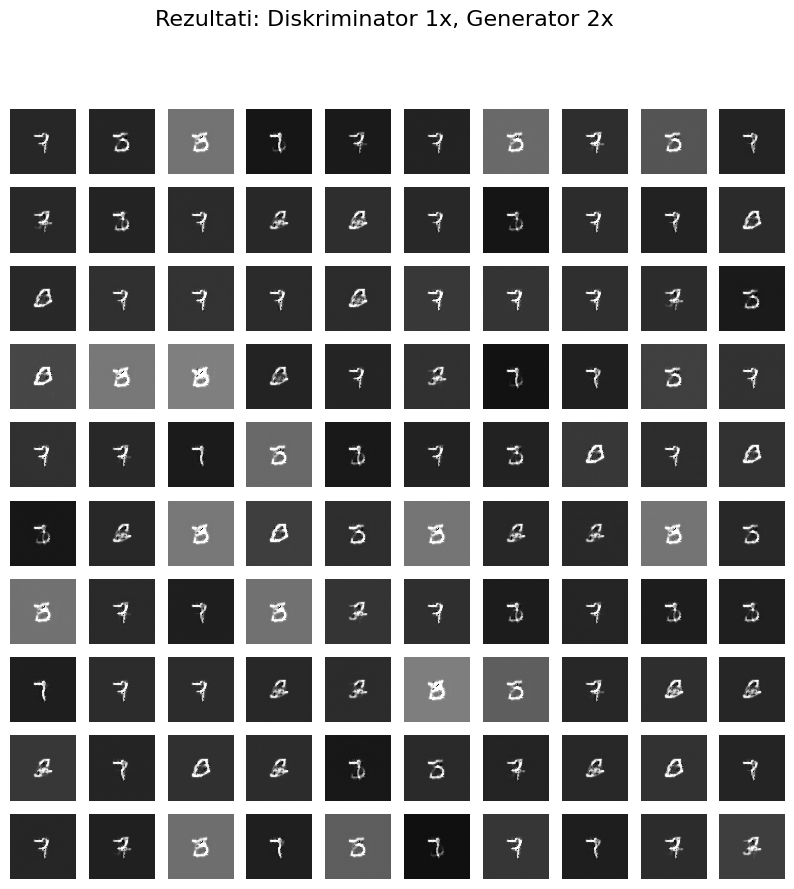

In [31]:
gmodel_d1g2 = Generator()
dmodel_d1g2 = Discriminator()

# Ovo je scenarij u kojem G ima više prilika za učenje (očekuje se mode collapse)
print("--- Treniranje: D:1x, G:2x ---")
gmodel_d1g2, dmodel_d1g2 = train(gmodel_d1g2, dmodel_d1g2, n_epochs=20, batch_size=128, device=device, d_updates=1, g_updates=2)

random_sample_d1g2 = gmodel_d1g2(torch.randn(100, 100, 1, 1).to(device)).view(100, 64, 64).data.cpu().numpy()
plt.figure(figsize=(10, 10))
for idx in range(100):
    plt.subplot(10, 10, idx+1)
    plt.imshow(random_sample_d1g2[idx, ...], cmap='gray')
    plt.axis('off')
plt.suptitle('Rezultati: Diskriminator 1x, Generator 2x', fontsize=16)
plt.show()

--- Treniranje: BEZ Batch Normalizacije ---


100%|██████████| 469/469 [00:16<00:00, 28.76it/s]


[1/20 - D:1x / G:1x]: d_loss = 1.33583 g_loss = 1.79623


100%|██████████| 469/469 [00:16<00:00, 28.66it/s]


[2/20 - D:1x / G:1x]: d_loss = 0.80362 g_loss = 2.79207


100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


[3/20 - D:1x / G:1x]: d_loss = 0.53350 g_loss = 3.79502


100%|██████████| 469/469 [00:16<00:00, 28.63it/s]


[4/20 - D:1x / G:1x]: d_loss = 0.38909 g_loss = 4.50555


100%|██████████| 469/469 [00:16<00:00, 28.65it/s]


[5/20 - D:1x / G:1x]: d_loss = 0.37817 g_loss = 4.88940


100%|██████████| 469/469 [00:16<00:00, 28.66it/s]


[6/20 - D:1x / G:1x]: d_loss = 0.34451 g_loss = 5.11411


100%|██████████| 469/469 [00:16<00:00, 28.65it/s]


[7/20 - D:1x / G:1x]: d_loss = 0.32719 g_loss = 4.91478


100%|██████████| 469/469 [00:16<00:00, 28.65it/s]


[8/20 - D:1x / G:1x]: d_loss = 0.31702 g_loss = 4.86005


100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


[9/20 - D:1x / G:1x]: d_loss = 0.33656 g_loss = 4.79454


100%|██████████| 469/469 [00:16<00:00, 28.63it/s]


[10/20 - D:1x / G:1x]: d_loss = 0.37851 g_loss = 4.14553


100%|██████████| 469/469 [00:16<00:00, 28.65it/s]


[11/20 - D:1x / G:1x]: d_loss = 0.40955 g_loss = 3.99401


100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


[12/20 - D:1x / G:1x]: d_loss = 0.37744 g_loss = 3.69402


100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


[13/20 - D:1x / G:1x]: d_loss = 0.38723 g_loss = 3.53163


100%|██████████| 469/469 [00:16<00:00, 28.63it/s]


[14/20 - D:1x / G:1x]: d_loss = 0.42167 g_loss = 3.36844


100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


[15/20 - D:1x / G:1x]: d_loss = 81.09610 g_loss = 0.99290


100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


[16/20 - D:1x / G:1x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


[17/20 - D:1x / G:1x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:16<00:00, 28.63it/s]


[18/20 - D:1x / G:1x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:16<00:00, 28.65it/s]


[19/20 - D:1x / G:1x]: d_loss = 100.00000 g_loss = 0.00000


100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


[20/20 - D:1x / G:1x]: d_loss = 100.00000 g_loss = 0.00000


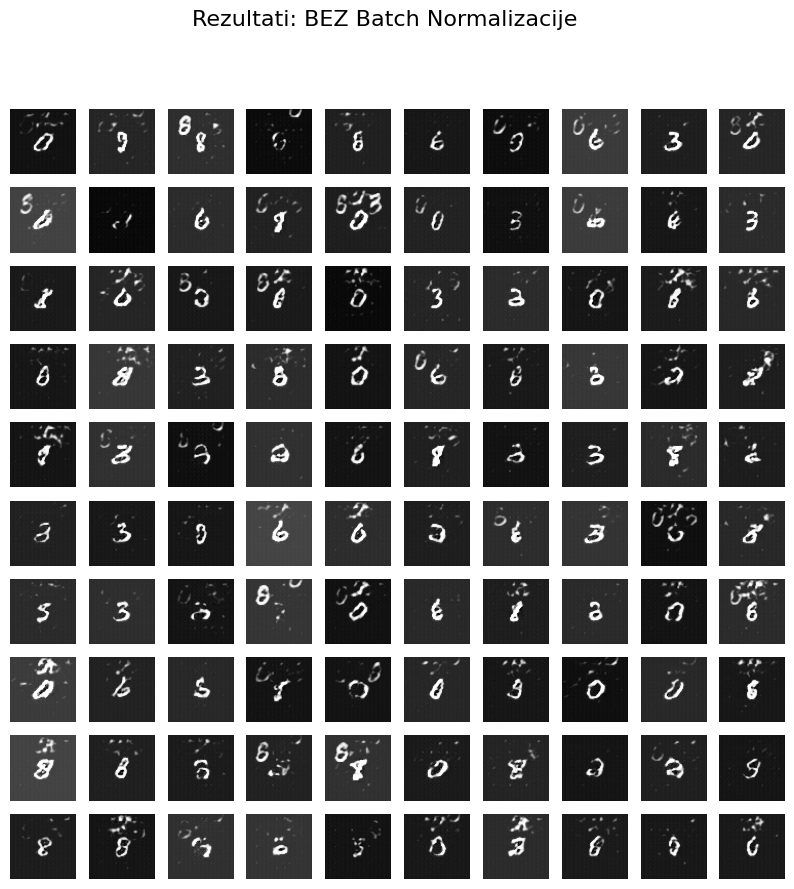

In [32]:
gmodel_nobn = GeneratorNoBN()
dmodel_nobn = DiscriminatorNoBN()

print("--- Treniranje: BEZ Batch Normalizacije ---")
# Omjer 1:1
gmodel_nobn, dmodel_nobn = train(gmodel_nobn, dmodel_nobn, n_epochs=20, batch_size=128, device=device, d_updates=1, g_updates=1)

random_sample_nobn = gmodel_nobn(torch.randn(100, 100, 1, 1).to(device)).view(100, 64, 64).data.cpu().numpy()
plt.figure(figsize=(10, 10))
for idx in range(100):
    plt.subplot(10, 10, idx+1)
    plt.imshow(random_sample_nobn[idx, ...], cmap='gray')
    plt.axis('off')
plt.suptitle('Rezultati: BEZ Batch Normalizacije', fontsize=16)
plt.show()

In [36]:
with open('zad_gan.th', 'wb') as f:
    torch.save(gmodel_d1g2.state_dict(), f)